In [3]:
from gurobipy import *
import pypsa
import pandas as pd
from dataclasses import dataclass

C:\Users\Mikol\anaconda3\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [10]:
climatic_year = 2000
time_horizon_in_hours = 365 * 24
network = pypsa.Network()

In [11]:
def add_germanya(network: pypsa.Network(), climatic_year: int, time_horizon_in_hours: int):
    full_demand = pd.read_csv("./data/demand_2030_germany.csv", sep=";", index_col=1, parse_dates=True).groupby(pd.Grouper(key="climatic_year"))
    full_wind_on_shore = pd.read_csv("./data/capa_factor_2030_germany_onshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
    full_solar = pd.read_csv("./data/capa_factor_2030_germany_solar.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))
    full_wind_off_shore = pd.read_csv("./data/capa_factor_2030_germany_offshore.csv", index_col=1, parse_dates=True, sep=";").groupby(pd.Grouper(key="climatic_year"))

    demand = full_demand.get_group(climatic_year)
    wind_on_shore = full_wind_on_shore.get_group(climatic_year)
    wind_off_shore = full_wind_off_shore.get_group(climatic_year)
    solar_pv = full_solar_pv.get_group(climatic_year)
    
    network.snapshots = demand.index[0:time_horizon_in_hours]
    
    network.add("Bus", name="Germany", x=13.404954, y=52.520008)
    
    @dataclass
    class FuelSources:
    name: str
    co2_emissions: float
    committable: bool
    min_up_time: float
    min_down_time: float
    primary_cost: float = None  # € / MWh (multiply this by the efficiency of your power plant to get the marginal cost)

    def return_as_dict(self, keys):
        return {key: self.__dict__[key] for key in keys}

    def carrier_characteristics(self):
        return self.return_as_dict(["name", "co2_emissions"])

    def generator_characteristics(self):
        return self.return_as_dict(["committable", "min_up_time", "min_down_time"]) 

    fuel_sources = {
    "Coal": FuelSources("Coal", 760, False, 24, 24, 160),
    "Gas": FuelSources("Gas", 370, False, 0, 0, 120),
    "Oil": FuelSources("Oil", 406, False, 1, 1, 100),
    "Uranium": FuelSources("Uranium", 0, False, 48, 240, 10),
    "Solar": FuelSources("Solar", 0, False, 0, 0, 5),
    "Wind": FuelSources("Wind", 0, False, 0, 0, 5),
    "Hydro": FuelSources("Hydro", 0, False, 0, 0, 5),
    "Biomass": FuelSources("Biomass", 0, False, 12, 12, 10)
    }

    for fuel_source in fuel_sources.values():
    network.add("Carrier", **fuel_source.carrier_characteristics())

    generators = [
    {"name": "GER-Hydro_ROR","bus": "Germany", "carrier": "Hydro", "p_nom": 3933, "p_min_pu": 0, "p_max_pu": 1,
     "marginal_cost": fuel_sources["Hydro"].primary_cost, "efficiency": 1,
     **(fuel_sources["Hydro"].generator_characteristics())},
    {"name": "GER-WindOnshore","bus": "Germany", "carrier": "Wind", "p_nom": 115000, "p_min_pu": 0, "p_max_pu": wind_on_shore[0:time_horizon_in_hours]["value"].values,
     "marginal_cost": fuel_sources["Wind"].primary_cost, "efficiency": 1,
     **(fuel_sources["Wind"].generator_characteristics())},
    {"name": "GER-WindOffshore","bus": "Germany", "carrier": "Wind", "p_nom": 30185, "p_min_pu": 0, "p_max_pu": wind_off_shore[0:time_horizon_in_hours]["value"].values,
     "marginal_cost": fuel_sources["Wind"].primary_cost, "efficiency": 1,
     **(fuel_sources["Wind"].generator_characteristics())},
    {"name": "GER-Solar","bus": "Germany", "carrier": "Solar", "p_nom": 215002, "p_min_pu": 0, "p_max_pu": solar_pv[0:time_horizon_in_hours]["value"].values,
     "marginal_cost": fuel_sources["Solar"].primary_cost, "efficiency": 1,
     **(fuel_sources["Solar"].generator_characteristics())},
    {"name": "GER-Coal","bus": "Germany", "carrier": "Coal", "p_nom": 0, "p_min_pu": 0, "p_max_pu": 1,
     "marginal_cost": fuel_sources["Coal"].primary_cost, "efficiency": 0.40,
     **(fuel_sources["Coal"].generator_characteristics())},
    {"name": "GER-Biomass","bus": "Germany", "carrier": "Biomass", "p_nom": 13067, "p_min_pu": 0, "p_max_pu": 1,
     "marginal_cost": fuel_sources["Biomass"].primary_cost, "efficiency": 0.3999,
     **(fuel_sources["Biomass"].generator_characteristics())},
     {"name": "GER-CCGT","bus": "Germany", "carrier": "Gas", "p_nom": 35504, "p_min_pu": 0, "p_max_pu": 1,
     "marginal_cost": fuel_sources["Gas"].primary_cost, "efficiency": 0.60,
     **(fuel_sources["Gas"].generator_characteristics())},
    {"name": "GER-Oil","bus": "Germany", "carrier": "Oil", "p_nom": 1885, "p_min_pu": 0, "p_max_pu": 1,
     "marginal_cost": fuel_sources["Oil"].primary_cost, "efficiency": 0.45,
     **(fuel_sources["Oil"].generator_characteristics())},
         {"name": "GER-Underproduction","bus": "Germany", "carrier": "Gas", "p_nom": 1000000, "p_min_pu": 0, "p_max_pu": 1,
     "marginal_cost": 10000000, "efficiency": 0.45,
     **(fuel_sources["Gas"].generator_characteristics())},
]

    
    storage_units = [
        {"name": "GER-PumpedHydroOL", "bus": "Germany", "carrier": "Hydro", "p_nom": 2144.10, "p_min_pu": -0.8680, "p_max_pu": 1,
    "max_hours": 204, "efficiency_store": 0.93, "efficiency_dispatch": 1, "state_of_charge_initial": 200000},
        {"name": "GER-PumpedHydroCL", "bus": "Germany", "carrier": "Hydro", "p_nom": 7009.84, "p_min_pu": -1.0224, "p_max_pu": 1,
    "max_hours": 39.39, "efficiency_store": 0.93, "efficiency_dispatch": 1, "state_of_charge_initial": 150000},
        {"name": "Battery", "bus": "Germany", "p_nom": 3200.40, "p_min_pu": -1, "p_max_pu": 1,
    "max_hours": 17.79, "efficiency_store": 0.90, "efficiency_dispatch": 0.90, "state_of_charge_initial":30000},
    ]
    
    for generator in generators:
    network.add("Generator", **generator, )
    

    for storage_unit in storage_units:
    network.add("StorageUnit", **storage_unit, )


    loads = [
    {"name": "Germany-load", "bus": "Germany", "carrier": "AC", "p_set": demand[0:time_horizon_in_hours]["value"].values},
    ]   
    
    for load in loads:
    network.add("Load", **load)

In [12]:
add_scandinavia(network, climatic_year, time_horizon_in_hours)

In [13]:
network

PyPSA Network
Components:
 - Bus: 1
 - Generator: 8
 - Load: 2
 - Store: 4
Snapshots: 8760

In [14]:
result = network.optimize(solver_name="gurobi")
print(result)   

Index(['Curtailment-load'], dtype='object', name='Load')
Index(['Curtailment-load'], dtype='object', name='Load')
INFO:linopy.model: Solve problem using Gurobi solver


Set parameter Username


INFO:gurobipy.gurobipy:Set parameter Username


Academic license - for non-commercial use only - expires 2024-11-21


INFO:gurobipy.gurobipy:Academic license - for non-commercial use only - expires 2024-11-21
INFO:linopy.io:Writing objective.
Writing binary variables.: 100%|██████████| 3/3 [00:00<00:00, 19.50it/s]
INFO:linopy.io: Writing time: 4.82s


Read LP format model from file C:\Users\Mikol\AppData\Local\Temp\linopy-problem-s32csgh8.lp


INFO:gurobipy.gurobipy:Read LP format model from file C:\Users\Mikol\AppData\Local\Temp\linopy-problem-s32csgh8.lp


Reading time = 0.99 seconds


INFO:gurobipy.gurobipy:Reading time = 0.99 seconds


obj: 429253 rows, 271560 columns, 1304677 nonzeros


INFO:gurobipy.gurobipy:obj: 429253 rows, 271560 columns, 1304677 nonzeros


Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)


INFO:gurobipy.gurobipy:Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)


INFO:gurobipy.gurobipy:


CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


INFO:gurobipy.gurobipy:CPU model: Intel(R) Core(TM) i5-9300H CPU @ 2.40GHz, instruction set [SSE2|AVX|AVX2]


Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy.gurobipy:Thread count: 4 physical cores, 8 logical processors, using up to 8 threads


INFO:gurobipy.gurobipy:


Optimize a model with 429253 rows, 271560 columns and 1304677 nonzeros


INFO:gurobipy.gurobipy:Optimize a model with 429253 rows, 271560 columns and 1304677 nonzeros


Model fingerprint: 0x2d58566e


INFO:gurobipy.gurobipy:Model fingerprint: 0x2d58566e


Variable types: 140160 continuous, 131400 integer (131400 binary)


INFO:gurobipy.gurobipy:Variable types: 140160 continuous, 131400 integer (131400 binary)


Coefficient statistics:


INFO:gurobipy.gurobipy:Coefficient statistics:


  Matrix range     [1e+00, 1e+05]


INFO:gurobipy.gurobipy:  Matrix range     [1e+00, 1e+05]


  Objective range  [5e+00, 1e+05]


INFO:gurobipy.gurobipy:  Objective range  [5e+00, 1e+05]


  Bounds range     [1e+00, 1e+00]


INFO:gurobipy.gurobipy:  Bounds range     [1e+00, 1e+00]


  RHS range        [1e+00, 1e+05]


INFO:gurobipy.gurobipy:  RHS range        [1e+00, 1e+05]


Presolve removed 429251 rows and 271557 columns


INFO:gurobipy.gurobipy:Presolve removed 429251 rows and 271557 columns


Presolve time: 4.36s


INFO:gurobipy.gurobipy:Presolve time: 4.36s


Presolved: 2 rows, 3 columns, 4 nonzeros


INFO:gurobipy.gurobipy:Presolved: 2 rows, 3 columns, 4 nonzeros


Variable types: 2 continuous, 1 integer (1 binary)


INFO:gurobipy.gurobipy:Variable types: 2 continuous, 1 integer (1 binary)


INFO:gurobipy.gurobipy:


Root relaxation: objective 3.307805e+09, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy.gurobipy:Root relaxation: objective 3.307805e+09, 0 iterations, 0.00 seconds (0.00 work units)


INFO:gurobipy.gurobipy:


    Nodes    |    Current Node    |     Objective Bounds      |     Work


INFO:gurobipy.gurobipy:    Nodes    |    Current Node    |     Objective Bounds      |     Work


 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy.gurobipy: Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time


INFO:gurobipy.gurobipy:


*    0     0               0    3.307805e+09 3.3078e+09  0.00%     -    4s


INFO:gurobipy.gurobipy:*    0     0               0    3.307805e+09 3.3078e+09  0.00%     -    4s


INFO:gurobipy.gurobipy:


Explored 1 nodes (0 simplex iterations) in 4.65 seconds (6.48 work units)


INFO:gurobipy.gurobipy:Explored 1 nodes (0 simplex iterations) in 4.65 seconds (6.48 work units)


Thread count was 8 (of 8 available processors)


INFO:gurobipy.gurobipy:Thread count was 8 (of 8 available processors)


INFO:gurobipy.gurobipy:


Solution count 1: 3.30781e+09 


INFO:gurobipy.gurobipy:Solution count 1: 3.30781e+09 


INFO:gurobipy.gurobipy:


Optimal solution found (tolerance 1.00e-04)


INFO:gurobipy.gurobipy:Optimal solution found (tolerance 1.00e-04)


Best objective 3.307805101850e+09, best bound 3.307805101837e+09, gap 0.0000%


INFO:gurobipy.gurobipy:Best objective 3.307805101850e+09, best bound 3.307805101837e+09, gap 0.0000%
INFO:linopy.constants: Optimization successful: 
Status: ok
Termination condition: optimal
Solution: 271560 primals, 0 duals
Objective: 3.31e+09
Solver model: available
Solver message: 2



('ok', 'optimal')


<AxesSubplot:xlabel='Generator', ylabel='GW'>

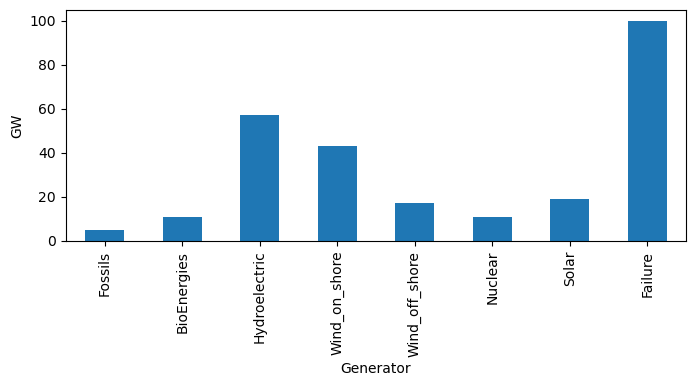

In [15]:
network.generators.p_nom_opt.div(1e3).plot.bar(ylabel="GW", figsize=(8, 3))

array([<AxesSubplot:xlabel='snapshot', ylabel='GW'>,
       <AxesSubplot:xlabel='snapshot', ylabel='GW'>,
       <AxesSubplot:xlabel='snapshot', ylabel='GW'>,
       <AxesSubplot:xlabel='snapshot', ylabel='GW'>,
       <AxesSubplot:xlabel='snapshot', ylabel='GW'>,
       <AxesSubplot:xlabel='snapshot', ylabel='GW'>,
       <AxesSubplot:xlabel='snapshot', ylabel='GW'>,
       <AxesSubplot:xlabel='snapshot', ylabel='GW'>], dtype=object)

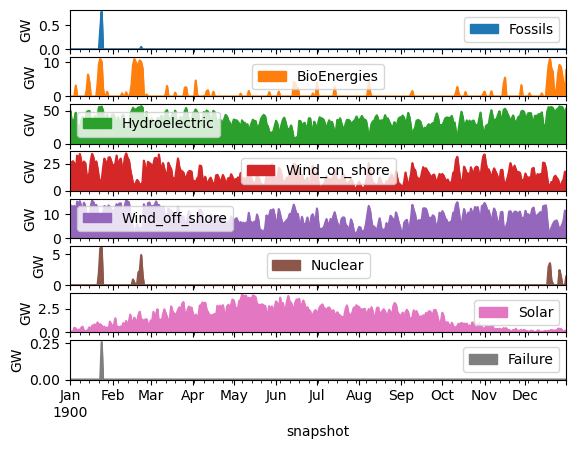

In [16]:
network.generators_t.p.resample('D').mean().div(1e3).plot.area(subplots=True, ylabel="GW")